# Chapter 15: CLIP-Guided VQGAN

This chapter covers:

* Using CLIP guided VQGAN to generate images based on text prompts
* Using a pretrained CLIP model to assess the similarity between an image and a text prompt
* Modifying the values in the latent space so the decoded matches with text
* Customizing PyTorch autograd functions

The combination of contrastive language-image pre-training (CLIP) and vector quantized generative adversarial network (VQGAN) represents a powerful approach for generating images from text prompts. This method uses the strengths of both models to produce high-quality images that align with given textual descriptions.

We discussed the idea behind CLIP in Chapte 9. CLIP is multi-modal Transformer designed by OpenAI to understand the relationship between textual descriptions and image. The model is first proposed in the paper Learning Transferable Visual Models From Natural Language Supervision by OpenAI researchers Alec Radford et al. in 2021 (https://arxiv.org/abs/2103.00020). The CLIP model is trained on a vast dataset of images paired with captions, learning to map images and text into a shared embedding space. Given a text prompt, CLIP can rank images based on how well they match the description. It provides a powerful way to evaluate the similarity between images and the text description. In Chapter 9, we trained a CLIP model from scratch by using image-caption pairs from the Flickr 8k dataset. We can find an image best matching the text prompt after training the model.

In the last chapter, we discussed in detail on how vector quantized generative adversarial network (VQGAN) works. VQGAN was first proposed in the paper Taming Transformers for High-Resolution Image Synthesis by Patrick Esser, Robin Rombach, and Björn Ommer in 2021 (https://arxiv.org/abs/2012.09841). In essence, the model combines GANs and vector quantization techniques to generate images with high fidelity and coherence: VQGAN learns a codebook of image features during training. When generating an image, it assembles these features to produce a coherent image that matches the given text description.

In this chapter, you'll learn how to generate images from text prompts by combining CLIP with VQGAN. You'll first provide a prompt and use a pre-trained text encoder in CLIP to map this prompt to an embedding in the shared text-image space. We'll then use a trained VQGAN to generate images iteratively, guided by the trained CLIP model. To generate an image from the given text prompt, we first initialize a random image within the latent space of the VQGAN model. Different latent code can be decoded by the trained VQGAN to generate different images. At first, the decoded images do not match the give text prompt at all. However, we can modify the latent code to generate images that better match the text embedding as we progress. Iterating through this process, we continuously adjust the latent code until the generated image closely aligns with the text prompt. In a way, the CLIP model serves as the perceptor while the VQGAN model serves as the generator in this situation. 

The method of combining CLIP and VQGAN was popularized in the blog post by Katherine Crowson (aka @RiversHaveWings) and various implementations on GitHub, but it was not formally introduced in an academic paper. A trained CLIP model provides a robust way to evaluate the semantic alignment between text and images, enabling text-guidance. At the same time, VQGAN offers a powerful generative model capable of producing high-quality images based on the guidance provided by CLIP. DALL-E (the predecessor of DALL-E 2) is an text-to-image model like VQGAN+CLIP. However, DALL-E is not open-sourced. Therefore, VQGAN+CLIP can be seen as an attempt to repliate how DALL-E works.

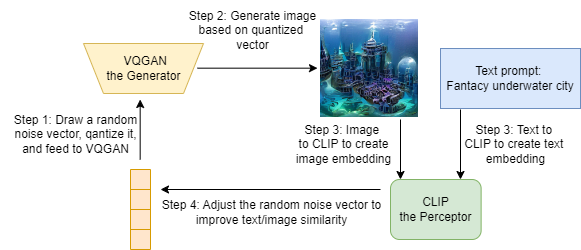

The above figure is a diagram of the steps involved in text to image generation with CLIP and VQGAN. To generate an image, a random noise vector is drawn from the latent space in VQGAN (step 1). The vector is quantized and fed to the VQGAN to create an image (step 2). Both the image and the text prompt are presented to the trained CLIP model to calculate the similarity between the text embedding and the image embedding (step 3). We then adjust the values in the random noise vector to increase the similarity between the text embeddings and the image embedding. We then repeat steps 2 to 4 many iterations until the generated image matches the text prompt. 

# 1. A Pre-Trained CLIP Model
In this section, we load a pre-trained CLIP model to guide the image generation process. 

First, make sure you have cloned the GitHub repository by OpenAI, as we discussed in Chapter 9. If not, run the following code cell in Jupyter Notebook to clone the OpenAI GitHub repository to place it in the local folder:

In [1]:
!git clone https://github.com/openai/CLIP

Now, all the files related to the OpenAI CLIP model are placed in the /CLIP/ folder on your computer. We'll use the sys library to give Python access to the folder as follows:

In [2]:
import sys

#sys.path.append("./CLIP")
sys.path.append('../CLIPdiffusion/CLIP')

We'll load the pre-trained CLIP model as follows:

In [3]:
import torch
import clip

clip_model='ViT-B/32'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
perceptor = clip.load(clip_model, jit=False)[0].eval()
perceptor = perceptor.requires_grad_(False).to(device)

Note we have frozen the CLIP model during the image generation process by using the requires_grad_(False) method. 

# 2. Load the Pre-Trained VQGAN
In this section, we load a pre-trained VQGAN model to generate images. 

First, make sure you have cloned the taming-transformers GitHub repository, as we discussed in the previous two chapters. If not, run the following code cell in Jupyter Notebook to clone the OpenAI GitHub repository to place it in the local folder:

In [4]:
!git clone https://github.com/CompVis/taming-transformers

All files related to the taming-transformers GitHub repository are placed in the /taming-transformers/ folder on your computer. We'll use the sys library to give Python access to the folder as follows:

In [5]:
#sys.path.append("./taming-transformers")
sys.path.append('../VQGANtrain/taming-transformers')

We can now load the pretrained VQGAN model as follows:

In [6]:
from omegaconf import OmegaConf
from taming.models import vqgan

#vqgan_config='files/vqgan_imagenet_f16_16384.yaml'
#vqgan_checkpoint='files/vqgan_imagenet_f16_16384.ckpt'
vqgan_config=r'E:\ManningStuff\GAI\VQGAN\VQGAN-CLIP\checkpoints\vqgan_imagenet_f16_16384.yaml'
vqgan_checkpoint=r'E:\ManningStuff\GAI\VQGAN\VQGAN-CLIP\checkpoints\vqgan_imagenet_f16_16384.ckpt'

config = OmegaConf.load(vqgan_config)
model = vqgan.VQModel(**config.model.params)
model.eval().requires_grad_(False)
model.init_from_ckpt(vqgan_checkpoint)
del model.loss
model = model.to(device)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.


C:\Users\hlliu2\Anaconda3\envs\nlp\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\hlliu2\Anaconda3\envs\nlp\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


loaded pretrained LPIPS loss from taming/modules/autoencoder/lpips\vgg.pth
VQLPIPSWithDiscriminator running with hinge loss.
Restored from E:\ManningStuff\GAI\VQGAN\VQGAN-CLIP\checkpoints\vqgan_imagenet_f16_16384.ckpt


We have also frozen the VQGAN model during the image generation process by using the requires_grad_(False) method. 

# 3 A Few Helper Functions
As in the CLIP guided diffusion model, we'll define a few helper functions. 

## 3.1 Make Cutouts on Images
Instead of feeding one whole image to the CLIP model, we'll make 32 cutouts of the generated image and feed them to the CLIP model so that we extract more features out of the input image. 

In [7]:
from torch import nn

class MakeCutouts(nn.Module):
    def __init__(self, cut_size, cutn, cut_pow=1):
        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn
        self.cut_pow = cut_pow
        self.augs = nn.Sequential(
            K.RandomAffine(degrees=15, translate=0.1, p=0.7,
                           padding_mode='border'),
            K.RandomPerspective(0.7,p=0.7),
            K.ColorJitter(hue=0.1, saturation=0.1, p=0.7),
            K.RandomErasing((.1, .4), (.3, 1/.3), 
                            same_on_batch=True, p=0.7),
        )
        self.noise_fac = 0.1
        self.av_pool = nn.AdaptiveAvgPool2d((self.cut_size,
                                             self.cut_size))
        self.max_pool = nn.AdaptiveMaxPool2d((self.cut_size,
                                              self.cut_size))
    def forward(self, input):
        slideY, slideX = input.shape[2:4]
        max_size = min(slideX, slideY)
        min_size = min(slideX, slideY, self.cut_size)
        cutouts = []
        for _ in range(self.cutn):
            cutout=(self.av_pool(input)+self.max_pool(input))/2
            cutouts.append(cutout)
        batch = self.augs(torch.cat(cutouts, dim=0))
        if self.noise_fac:
            facs = batch.new_empty([self.cutn, 1, 1,
                        1]).uniform_(0, self.noise_fac)
            batch = batch + facs * torch.randn_like(batch)
        return batch

We then instantiate the class to create a function to make cutouts.

In [8]:
import kornia.augmentation as K

cut_size = perceptor.visual.input_resolution
f = 2**(model.decoder.num_resolutions - 1)
cutn=32
cut_pow=1
size=[512,512]
make_cutouts = MakeCutouts(cut_size, cutn, cut_pow)
toksX, toksY = size[0] // f, size[1] // f
sideX, sideY = toksX * f, toksY * f

## 3.2 Customize PyTorch Autograd Functions
Because vectors in the codebook are discrete, they are not differentiable. We'll instead use the derivative of the loss function with respect to the random noise vectors in the latent space (which are continuous), instead of the loss function with respect to the codebook vectors (which are discrete). 

We therefore define the following customized PyTorch autograd function:a.

In [9]:
class ReplaceGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x_forward, x_backward):
        ctx.shape = x_backward.shape
        return x_forward
    @staticmethod
    def backward(ctx, grad_in):
        return None, grad_in.sum_to_size(ctx.shape)
replace_grad = ReplaceGrad.apply

A custom PyTorch autograd function is a way for us to customize the backward formula. The above ReplaceGrad() class takes x1 and x2 as input. In the forward pass, it returns x1 and ignores x2. In the backward pass, it will pass all the gradients toward x2 and no gradient toward x1.

Later, we'll calculate the gradient of the loss function with respect to x_q and x, where x_q is the discrete codebook vector and x is the original continuous random noise vector. As a result, replace_grad(x_q, x) returns x_q in the forward pass and the gradient of the loss function with respect to x in the backward pass. The purpose is to calculate the gradient so that we can adjust model parameters in the training process.

We create another custom PyTorch autograd function to clamp the gradient so the gradient stays in the range (min, max). 

In [10]:
class ClampWithGrad(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, min, max):
        ctx.min = min
        ctx.max = max
        ctx.save_for_backward(input)
        return input.clamp(min, max)
    @staticmethod
    def backward(ctx, grad_in):
        input, = ctx.saved_tensors
        return grad_in * (grad_in * (input - input.clamp(ctx.min,
                         ctx.max)) >= 0), None, None
clamp_with_grad = ClampWithGrad.apply

# 4. Text to Image Generation with CLIP Guided VQGAN
To create an image based on a prompt, we first use the CLIP text encoder to convert the prompt into a text embedding. We first randomly draw a noise vector from the latent space in VQGAN and generate an image based on it. We then use CLIP to calculate similarity between the text embedding and the embedding of the generated image. We then tweak the values in the noise vector so that in the next iteration, the generation image will match the text description better, as measured by a similar image embedding with the text embedding. 

## 4.1 Create CLIP Guidance Based on the Text Embedding
First, we provide a text prompt.

In [11]:
texts="a fantasy underwater city"
target_images = []
texts = [phrase.strip() for phrase in texts.split("|")]
torch.manual_seed(42)

In the above example, we want to generate just one image with one prompt. If you want to provide multiple prompts to generate more than one image, put all them in a single text string, separated by the vertical divider ("|"). You can also provide a target image so that the generated image resembles the target image. Here we leave it blank. 

In [12]:
def parse_prompt(prompt):
    vals = prompt.rsplit(':', 2)
    vals = vals + ['', '1', '-inf'][len(vals):]
    return vals[0], float(vals[1]), float(vals[2])
class Prompt(nn.Module):
    def __init__(self, embed, weight=1., stop=float('-inf')):
        super().__init__()
        self.register_buffer('embed', embed)
        self.register_buffer('weight', torch.as_tensor(weight))
        self.register_buffer('stop', torch.as_tensor(stop))
    def forward(self, input):
        input_normed = F.normalize(input.unsqueeze(1), dim=2)
        embed_normed = F.normalize(self.embed.unsqueeze(0),
                                   dim=2)
        dists = input_normed.sub(embed_normed).norm(dim=2
                    ).div(2).arcsin().pow(2).mul(2)
        dists = dists * self.weight.sign()
        return self.weight.abs() * replace_grad(dists,
            torch.maximum(dists, self.stop)).mean()    
pMs = []
for prompt in texts:
    txt, weight, stop = parse_prompt(prompt)
    embed = perceptor.encode_text(
        clip.tokenize(txt).to(device)).float()
    pMs.append(Prompt(embed, weight, stop).to(device))

C:\Users\hlliu2\Anaconda3\envs\nlp\Lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


The list pMs contains the conditioning functions for image generation. It tells the VQGAN how to tweak the value in the noise vector so the generated image matches the text prompt better. 

## 4.2 Image Generation from VQGAN based on CLIP Guidance
Now that we have a conditioning function, we'll ask VQGAN to generate image iteratively until the generated image matches the prompt. 

We first randomly draw a noise vector from the latent space. 

In [13]:
import torchvision
import torch.nn.functional as F

e_dim = model.quantize.e_dim
n_toks = model.quantize.n_e
z_min = model.quantize.embedding.weight.min(
    dim=0).values[None, :, None, None]
z_max = model.quantize.embedding.weight.max(
    dim=0).values[None, :, None, None]

one_hot = F.one_hot(torch.randint(n_toks, [toksY * toksX],
                          device=device), n_toks).float()
z = one_hot @ model.quantize.embedding.weight
z = z.view([-1, toksY, toksX, e_dim]).permute(0, 3, 1, 2) 
z = torch.rand_like(z)*2

z_orig = z.clone()
z.requires_grad_(True)
opt = torch.optim.Adam([z], lr=0.13)
normalize = torchvision.transforms.Normalize(
    mean=[0.48145466, 0.4578275, 0.40821073],
    std=[0.26862954, 0.26130258, 0.27577711])

We'll also define a few functions. The first is the vector_quantize() function.

In [14]:
def vector_quantize(x, codebook):
    d = x.pow(2).sum(dim=-1, keepdim=True) + codebook.pow(
        2).sum(dim=1) - 2 * x @ codebook.T
    indices = d.argmin(-1)
    x_q = F.one_hot(indices, 
        codebook.shape[0]).to(d.dtype) @ codebook
    return replace_grad(x_q, x)

The function takes a continuous noise vector and returns a discrete quantized vector based on the codebook. 

We define a function synth() to calculate the gradient of the loss function with respect to the noise vector. 

In [15]:
def synth(z):
    z_q = vector_quantize(z.movedim(1, 3), 
              model.quantize.embedding.weight).movedim(3, 1)
    return clamp_with_grad(model.decode(z_q).add(1).div(2), 0, 1)

Next, we refine the image for 100 iterations. 

In [16]:
init_weight=0.004
outs=[]
for i in range(100):
    opt.zero_grad()
    # generate the image
    out = synth(z)
    outs.append(out)
    # use CLIP to encode the image as image embeddings
    iii = perceptor.encode_image(
        normalize(make_cutouts(out))).float()
    result = []
    if init_weight:
        result.append(F.mse_loss(z, z_orig) * init_weight / 2)
    for prompt in pMs:
        result.append(prompt(iii))
    loss = sum(result)
    loss.backward()
    opt.step()
    with torch.no_grad():
        z.copy_(z.maximum(z_min).minimum(z_max))  
    print(f"at iteration {i+1}, loss is {loss.item()}")

at iteration 1, loss is 0.972235918045044
at iteration 2, loss is 0.9638664126396179
at iteration 3, loss is 0.9539668560028076
at iteration 4, loss is 0.9590858221054077
at iteration 5, loss is 0.9465319514274597
at iteration 6, loss is 0.9444313645362854
at iteration 7, loss is 0.9586801528930664
at iteration 8, loss is 0.9543254375457764
at iteration 9, loss is 0.9575011730194092
at iteration 10, loss is 0.9598165154457092
at iteration 11, loss is 0.9581329822540283
at iteration 12, loss is 0.9601361155509949
at iteration 13, loss is 0.9611374735832214
at iteration 14, loss is 0.9597544074058533
at iteration 15, loss is 0.9568563103675842
at iteration 16, loss is 0.9539527297019958
at iteration 17, loss is 0.9502020478248596
at iteration 18, loss is 0.9472349286079407
at iteration 19, loss is 0.9552536606788635
at iteration 20, loss is 0.9517945051193237
at iteration 21, loss is 0.9410563707351685
at iteration 22, loss is 0.9363576769828796
at iteration 23, loss is 0.932729482650756

The final image is the tensor out, which has a shape of (1, 3, 512, 512). We can convert it to a PIL image and visualize it.

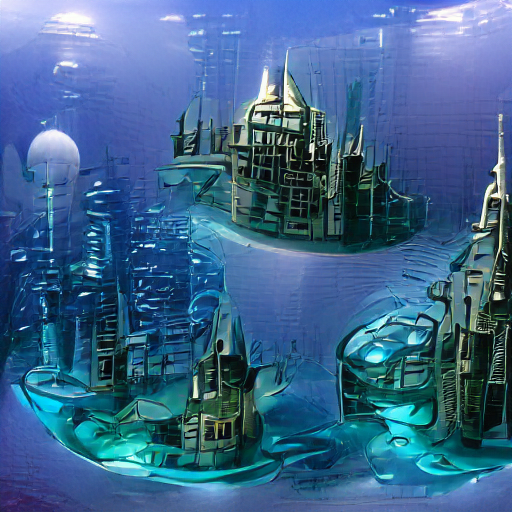

In [17]:
from torchvision.transforms.functional import to_pil_image

img=to_pil_image(out[0].clamp(0,1))
img.save("files/CLIPVQGAN.png")
img

The list *outs* contain all 100 intermediate images generated by the VQGAN. We can create a video as follows:

In [18]:
import imageio
import numpy as np

frames=[]
for img in outs:
    img = np.array(img.mul(255).clamp(0, 255)[0].cpu(
        ).detach().numpy().astype(np.uint8))
    img = np.transpose(img, (1, 2, 0)) 
    frames.append(img)
imageio.mimsave("files/CLIPVQGAN.gif",
                frames,fps=24)

You should see an animation of the intermediate results, CLIPVQGAN.gif in your /files/ folder. Alternatively, you can watch the animation on my website https://gattonweb.uky.edu/faculty/lium/v/CLIPVQGAN.gif. 